In [1]:
import pandas as pd
data=pd.read_csv('train.csv')
data.head(2)

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed


In [2]:
data['Attrition'].value_counts(normalize=True) * 100

Attrition
Stayed    52.451425
Left      47.548575
Name: proportion, dtype: float64

## Missing value

In [3]:
data.isnull().sum()

Employee ID                 0
Age                         0
Gender                      0
Years at Company            0
Job Role                    0
Monthly Income              0
Work-Life Balance           0
Job Satisfaction            0
Performance Rating          0
Number of Promotions        0
Overtime                    0
Distance from Home          0
Education Level             0
Marital Status              0
Number of Dependents        0
Job Level                   0
Company Size                0
Company Tenure              0
Remote Work                 0
Leadership Opportunities    0
Innovation Opportunities    0
Company Reputation          0
Employee Recognition        0
Attrition                   0
dtype: int64

## Finding Outliers

In [4]:
numeric_column=data.select_dtypes(include=['number'])
numeric_column_name= data.select_dtypes(include=['number']).columns
numeric_column_name=list(numeric_column_name)

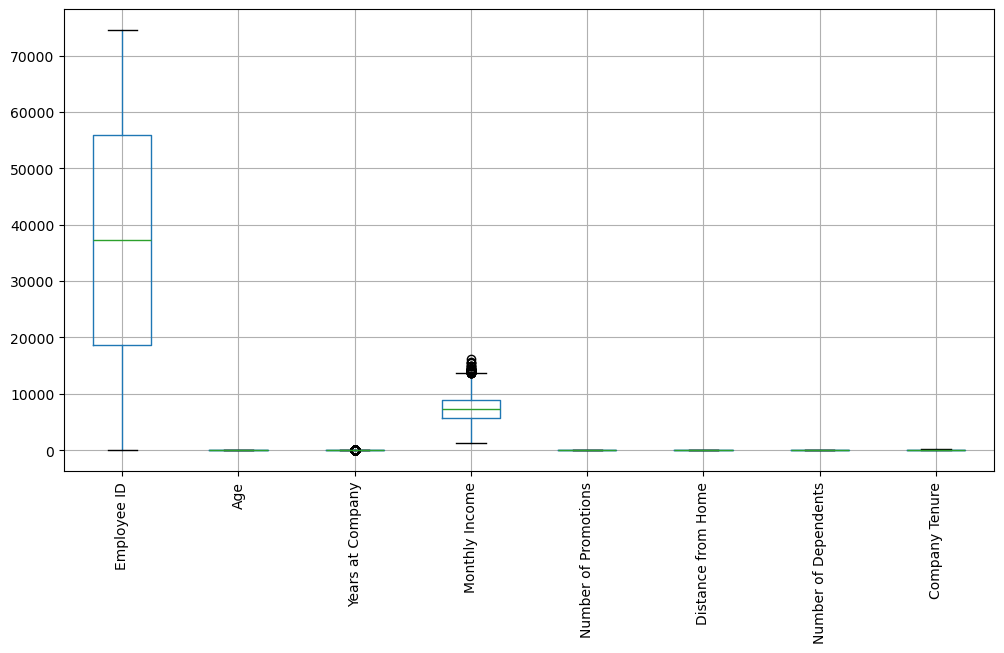

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
data.boxplot(column=numeric_column_name)
plt.xticks(rotation=90)
plt.show()

In [6]:
Q1=data['Monthly Income'].quantile(0.25)
Q3=data['Monthly Income'].quantile(0.75)
IQR= Q3-Q1
lower_limit= Q1-1.5*IQR
upper_limit= Q1+1.5*IQR
data['Monthly Income']=data['Monthly Income'].clip(lower_limit,upper_limit)

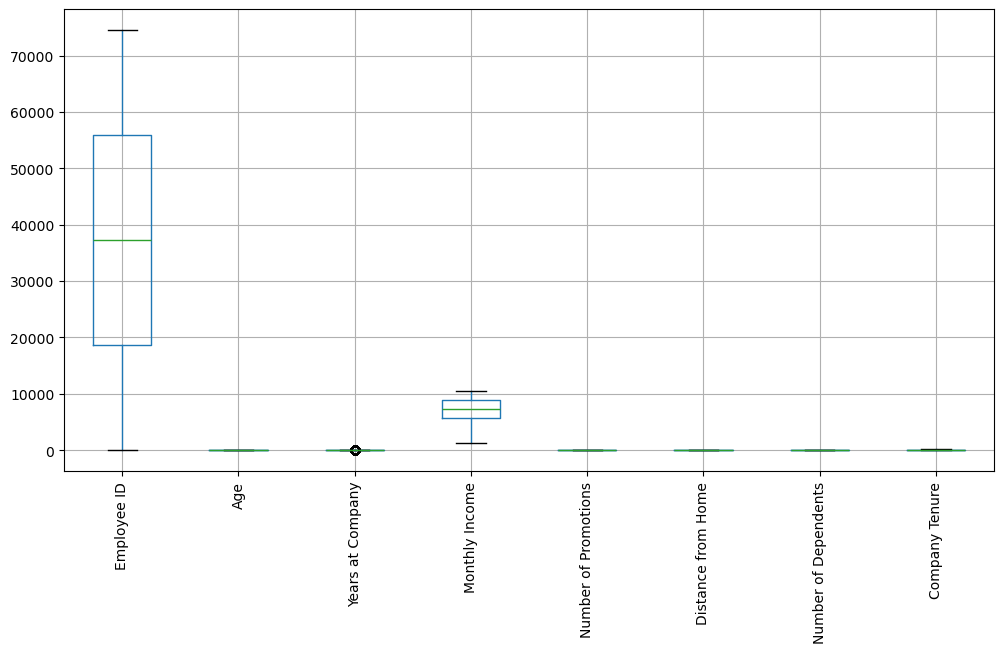

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
data.boxplot(column=numeric_column_name)
plt.xticks(rotation=90)
plt.show()

## Test train split

In [8]:
y=data['Attrition']
X=data.drop(['Attrition','Employee ID'], axis=1)

In [9]:
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

In [10]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for cols in cat_cols:
    le = LabelEncoder()
    X[cols] = le.fit_transform(X[cols].astype(str)) 
    label_encoders[cols] = le

In [11]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
cat_col_indices = [X.columns.get_loc(col) for col in cat_cols]


In [14]:
X_train.head(2)

,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Marital Status,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition
1991,0.926829,1,0.74,0,0.301471,1,1,0,0.0,0,...,2,0.666667,1,1,0.531746,1,0,0,0,1
1402,0.219512,0,0.02,0,0.351390,2,3,0,0.0,0,...,0,0.166667,2,2,0.031746,0,0,0,1,0


## Standardisation and Encoding 

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=0,
    use_label_encoder=False,
    eval_metric='auc',
    early_stopping_rounds=100
)

param_dist = {
    'n_estimators': randint(1000, 6000),     # around your 5000
    'learning_rate': uniform(0.01, 0.2),     # around 0.1    
    'reg_alpha': uniform(0, 2),              # around 1
    'reg_lambda': uniform(1, 10),            # around 6
    'subsample': uniform(0.6, 0.4),          # try subsampling
    'colsample_bytree': uniform(0.6, 0.4)    # for column sampling
}
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # number of parameter combinations to try
    scoring='roc_auc',  # or 'accuracy', 'f1', etc.
    cv=5,
    verbose=1,
    random_state=0,
    n_jobs=-1  # use all cores
)

# Fit on your resampled data
random_search.fit(X_train, y_train,
    eval_set=[(X_test, y_test)])
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

best_xgb_model = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-auc:0.79376
[1]	validation_0-auc:0.79704
[2]	validation_0-auc:0.81155
[3]	validation_0-auc:0.81370


In [25]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(
    colsample_bytree= 0.8092992213866799, 
    learning_rate= 0.02878810215168834, 
    max_depth= 2, 
    n_estimators=5182, 
    reg_alpha=0.6371379049026473, 
    reg_lambda=7.674103799636817, 
    subsample= 0.6527191449617569,
    random_state=0
)

classifier_xgb.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8092992213866799, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02878810215168834,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5182, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [26]:
#test train accuracies
y_pred_test=classifier_xgb.predict(X_test)
y_pred_train=classifier_xgb.predict(X_train)
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,roc_auc_score
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)
# Probabilities (for AUC)
y_proba_test = classifier_xgb.predict_proba(X_test)[:, 1]
y_proba_train = classifier_xgb.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_proba_train)
auc_test = roc_auc_score(y_test, y_proba_test)
print("Training AUC:", auc_train)
print("Testing AUC:", auc_test)

training accuracy: 0.7686144553043333
testing accuracy: 0.7595637583892617
training F1_score: 0.7795804195804196
testing F1_score: 0.7717062290903298
Training AUC: 0.8633643815364174
Testing AUC: 0.8487333594534152


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
#Model development
def model(hp):
    ann = tf.keras.models.Sequential()

    # Hyperparameters
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    l2_regularizer = hp.Float('l2_regularizer', min_value=0.0001, max_value=0.01, step=0.001)
    kernel_initializer = hp.Choice('kernel_initializer', values=['he_uniform', 'glorot_uniform', 'lecun_normal'])
    activation = hp.Choice('activation', values=['relu', 'tanh', 'LeakyReLU'])

    # input layer
    ann.add(tf.keras.layers.Input(shape=(X_train.shape[1],)
    ))
    #first hidden layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(256,kernel_initializer=kernel_initializer, activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)        
    ))
    #second hidden layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(128,kernel_initializer=kernel_initializer,activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
    ))
    #Third hidden layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(64,kernel_initializer=kernel_initializer,activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
    ))
    #output layer
    ann.add(tf.keras.layers.BatchNormalization())
    ann.add(tf.keras.layers.Dense(1,kernel_initializer=kernel_initializer, activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
    ))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

    return ann

# Create the tuner with 10 trials and save in folder
tuner = kt.RandomSearch(
    model,  
    objective='val_loss',  
    max_trials=20, 
    directory='cap_project2'
    )
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_auc',       # Monitor validation loss (you can change this to 'val_mae' if needed)
    patience=5,               # Number of epochs to wait for improvement (you can adjust this)
    restore_best_weights=True # Restore the best model weights after early stopping
)
# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping] )

Trial 20 Complete [00h 02m 07s]
val_loss: 0.5437253713607788

Best val_loss So Far: 0.49381083250045776
Total elapsed time: 01h 03m 22s


In [16]:
best_model = tuner.get_best_models(num_models=1)[0]

In [17]:
# evaluate model
val_loss, val_auc = best_model.evaluate(X_test, y_test)
print("\nBest Model Validation AUC:", val_auc)
print("\nBest Model Validation Loss:", val_loss) 

373/373 [==============================] - 2s 3ms/step - loss: 0.4938 - auc: 0.8395

Best Model Validation AUC: 0.8394941091537476

Best Model Validation Loss: 0.49381083250045776


## Sensitivity

In [29]:
import numpy as np

# Pick one sample from test set
x = X_test.iloc[0].values.reshape(1, -1)

# Create perturbation
epsilon = 1e-2
delta = np.random.normal(0, epsilon, size=x.shape)
x_perturbed = x + delta

# Make predictions (for any trained model)
y_pred = classifier_xgb.predict(x)
y_perturbed = classifier_xgb.predict(x_perturbed)

# Sensitivity
sensitivity = np.abs(y_perturbed - y_pred) / np.linalg.norm(delta)
print(f"Sensitivity: {sensitivity[0]:.4f}")


Sensitivity: 0.0000


## Logistic regression

In [134]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression(random_state=0)
classifier.fit(X_resampled, y_resampled)

LogisticRegression(random_state=0)

In [135]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 0.6037414965986394
testing accuracy: 0.6122448979591837
training F1_score: 0.2808641975308642
testing F1_score: 0.2692307692307692


## Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=500,criterion='entropy',random_state=0)
classifier.fit(X_resampled, y_resampled)

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=0)

In [137]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 1.0
testing accuracy: 0.8333333333333334
training F1_score: 1.0
testing F1_score: 0.0


## Decision tree

In [138]:
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(criterion='entropy',random_state=0)
classifier.fit(X_resampled, y_resampled)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [139]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 1.0
testing accuracy: 0.6938775510204082
training F1_score: 1.0
testing F1_score: 0.11764705882352941


## SVC

In [141]:
from sklearn.svm import SVC
classifier=SVC(kernel='rbf',random_state=0)
classifier.fit(X_resampled, y_resampled)

SVC(random_state=0)

In [142]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 0.7687074829931972
testing accuracy: 0.6768707482993197
training F1_score: 0.4538152610441767
testing F1_score: 0.18803418803418803


## neive bayes

In [143]:
from sklearn.naive_bayes import GaussianNB
classifier=GaussianNB()
classifier.fit(X_resampled, y_resampled)

GaussianNB()

In [144]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 0.5459183673469388
testing accuracy: 0.5510204081632653
training F1_score: 0.2457627118644068
testing F1_score: 0.21428571428571427


## GradientBoosting

In [145]:
from sklearn.ensemble import GradientBoostingClassifier

# Create GBM classifier
classifier = GradientBoostingClassifier(criterion='friedman_mse',  
                                        learning_rate=0.1,
                                        n_estimators=100,
                                        max_depth=3,
                                        random_state=0)

# Fit the model
classifier.fit(X_resampled, y_resampled)


GradientBoostingClassifier(random_state=0)

In [146]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 0.8767006802721088
testing accuracy: 0.8129251700680272
training F1_score: 0.39330543933054396
testing F1_score: 0.0


## lightgbm

In [148]:
pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.5 MB 495.5 kB/s eta 0:00:03
   ---------- ----------------------------- 0.4/1.5 MB 3.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.5 MB 2.8 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.4 MB/s eta 0:00:00


In [149]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Create LightGBM classifier
classifier = LGBMClassifier(objective='binary',      # or 'multiclass' for multi-class problems
                            learning_rate=0.1,
                            n_estimators=100,
                            max_depth=-1,            # -1 means no limit
                            random_state=0)

# Fit the model
classifier.fit(X_resampled, y_resampled)


[LightGBM] [Info] Number of positive: 986, number of negative: 986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5790
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(objective='binary', random_state=0)

In [150]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 1.0
testing accuracy: 0.8231292517006803
training F1_score: 1.0
testing F1_score: 0.037037037037037035


## catboost

In [151]:
pip install catboost

   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/102.5 MB 2.3 MB/s eta 0:00:45
   ---------------------------------------- 0.6/102.5 MB 7.4 MB/s eta 0:00:14
    --------------------------------------- 1.3/102.5 MB 10.6 MB/s eta 0:00:10
    --------------------------------------- 1.9/102.5 MB 11.1 MB/s eta 0:00:10
    --------------------------------------- 2.3/102.5 MB 11.0 MB/s eta 0:00:10
   - -------------------------------------- 2.7/102.5 MB 10.9 MB/s eta 0:00:10
   - -------------------------------------- 3.5/102.5 MB 11.2 MB/s eta 0:00:09
   - -------------------------------------- 4.0/102.5 MB 11.5 MB/s eta 0:00:09
   - -------------------------------------- 4.5/102.5 MB 11.4 MB/s eta 0:00:09
   -- ------------------------------------- 5.1/102.5 MB 11.7 MB/s eta 0:00:09
   -- ------------------------------------- 6.1/102.5 MB 12.6 MB/s eta 0:00:08
   -- ------------------------------------- 7.1/102.5 MB 13.4 

In [152]:
from catboost import CatBoostClassifier

# Create CatBoost classifier
classifier = CatBoostClassifier(iterations=100,
                                learning_rate=0.1,
                                depth=6,
                                loss_function='Logloss',  # Use 'MultiClass' for multi-class problems
                                verbose=0,                # Set >0 to see training output
                                random_state=0)

# Fit the model
classifier.fit(X_resampled, y_resampled)


In [153]:
#test train accuracies
y_pred_test=classifier.predict(X_test_transformed)
y_pred_train=classifier.predict(X_train_transformed)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 0.9566326530612245
testing accuracy: 0.826530612244898
training F1_score: 0.8449848024316109
testing F1_score: 0.0


## feature engineering

In [33]:
df = pd.get_dummies(data, columns=categorical_cols , dtype='int', drop_first=True)
X=df.drop(['Attrition'], axis=1)
y=df['Attrition']
y=pd.get_dummies(y, drop_first=True, dtype='int').iloc[:, 0]

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif, f_classif
BestFeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit=BestFeatures.fit(X,y)

In [35]:
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
f_Scores = pd.concat([df_columns,df_scores],axis=1)              
f_Scores.columns = ['Specs','Score']  
f_Scores

,Specs,Score
0,Employee ID,0.002959
1,Age,0.006067
2,Years at Company,0.005245
3,Monthly Income,0.002963
4,Number of Promotions,0.009245
5,Distance from Home,0.007611
6,Number of Dependents,0.007000
7,Company Tenure,0.000000
8,Gender_Male,0.007787
9,Job Role_Finance,0.000000


In [36]:
print(f_Scores.nlargest(20,'Score')) 

                           Specs     Score
28         Marital Status_Single  0.042933
30              Job Level_Senior  0.039205
27        Marital Status_Married  0.030899
33               Remote Work_Yes  0.026464
37       Company Reputation_Good  0.012372
13        Work-Life Balance_Fair  0.011336
4           Number of Promotions  0.009245
8                    Gender_Male  0.007787
14        Work-Life Balance_Good  0.007632
5             Distance from Home  0.007611
6           Number of Dependents  0.007000
1                            Age  0.006067
15        Work-Life Balance_Poor  0.006031
38       Company Reputation_Poor  0.005747
26           Education Level_PhD  0.005557
24   Education Level_High School  0.005527
2               Years at Company  0.005245
31           Company Size_Medium  0.005039
18    Job Satisfaction_Very High  0.004241
34  Leadership Opportunities_Yes  0.003861


## multicollinearity check

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                              feature        VIF
0                         Employee ID   3.844141
1                                 Age  14.048708
2                    Years at Company   4.837130
3                      Monthly Income  35.814631
4                Number of Promotions   1.687600
5                  Distance from Home   3.922583
6                Number of Dependents   2.092907
7                      Company Tenure   6.930424
8                         Gender_Male   2.186172
9                    Job Role_Finance   3.189032
10                Job Role_Healthcare   4.164096
11                     Job Role_Media   2.054076
12                Job Role_Technology   5.975306
13             Work-Life Balance_Fair   2.560189
14             Work-Life Balance_Good   2.948659
15             Work-Life Balance_Poor   1.716853
16               Job Satisfaction_Low   1.193128
17            Job Satisfaction_Medium   1.387230
18         Job Satisfaction_Very High   1.396378
19   Performance Rat

In [38]:
print(vif_data.nlargest(15,'VIF'))

                    feature        VIF
3            Monthly Income  35.814631
1                       Age  14.048708
7            Company Tenure   6.930424
12      Job Role_Technology   5.975306
37  Company Reputation_Good   5.355190
2          Years at Company   4.837130
10      Job Role_Healthcare   4.164096
27   Marital Status_Married   4.088236
5        Distance from Home   3.922583
0               Employee ID   3.844141
31      Company Size_Medium   3.335247
9          Job Role_Finance   3.189032
28    Marital Status_Single   3.153583
14   Work-Life Balance_Good   2.948659
38  Company Reputation_Poor   2.761765


## columns deleted high collinearity >6 from top 20 columns

In [84]:

            columns=[ 'Job Level_Senior','Marital Status_Married','Remote Work_Yes','Company Reputation_Good','Work-Life Balance_Fair', 
          'Number of Promotions',  
                   'Gender_Male',  
      'Work-Life Balance_Good',  
            'Distance from Home' , 
           'Number of Dependents',                              
       'Work-Life Balance_Poor',  
       'Company Reputation_Poor',  
           'Education Level_PhD',  
   'Education Level_High School', 
               'Years at Company', 
           'Company Size_Medium',  
    'Job Satisfaction_Very High',  
  'Leadership Opportunities_Yes','Attrition' ]
newdf = df.reindex(columns=columns)
newdf.head()  

,Job Level_Senior,Marital Status_Married,Remote Work_Yes,Company Reputation_Good,Work-Life Balance_Fair,Number of Promotions,Gender_Male,Work-Life Balance_Good,Distance from Home,Number of Dependents,Work-Life Balance_Poor,Company Reputation_Poor,Education Level_PhD,Education Level_High School,Years at Company,Company Size_Medium,Job Satisfaction_Very High,Leadership Opportunities_Yes,Attrition
0,0,1,0,0,0,2,1,0,22,0,0,0,0,0,19,1,0,0,Stayed
1,0,0,0,0,0,3,0,0,21,3,1,0,0,0,4,1,0,0,Stayed
2,0,1,0,0,0,0,0,1,11,3,0,1,0,0,10,1,0,0,Stayed
3,0,0,1,1,0,1,0,1,27,2,0,0,0,1,7,0,0,0,Stayed
4,1,0,0,0,1,0,1,0,71,0,0,0,0,1,41,1,1,0,Stayed


In [85]:
#columns=['Job Level_Senior','Marital Status_Married','Remote Work_Yes','Number of Promotions','Work-Life Balance_Fair','Gender_Male',
#'Education Level_PhD','Work-Life Balance_Poor','Company Reputation_Good','Work-Life Balance_Good','Job Level_Mid','Leadership Opportunities_Yes',  
#'Employee Recognition_Low','Company Size_Medium']
#newdf = df.reindex(columns=columns)
#newdf.head()     

In [86]:
X=newdf.iloc[0:,:-1]
y=newdf.iloc[0:,-1]
y=pd.get_dummies(y, drop_first=True, dtype='int').iloc[:, 0]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
from xgboost import XGBClassifier
classifier_xgb=XGBClassifier(n_estimators=2000,max_depth=2,reg_lambda=100,reg_alpha=10,random_state=0)
classifier_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [88]:
#test train accuracies
y_pred_test=classifier_xgb.predict(X_test)
y_pred_train=classifier_xgb.predict(X_train)
from sklearn.metrics import confusion_matrix, accuracy_score
acc_train=accuracy_score(y_train,y_pred_train)
acc_test=accuracy_score(y_test,y_pred_test)
print("training accuracy:",acc_train)
print("testing accuracy:",acc_test)
f1_train=f1_score(y_train,y_pred_train)
f1_test=f1_score(y_test,y_pred_test)
print("training F1_score:",f1_train)
print("testing F1_score:",f1_test)

training accuracy: 0.7369226897101389
testing accuracy: 0.7301174496644295
training F1_score: 0.7474173865764514
testing F1_score: 0.739112805125294
